In [1]:
!wget -O B183.jpg https://drive.google.com/u/0/uc?id=1D5_iMzwCKfMnWMtC8oYDHtWyQT83GSP0&export=download
!wget -O 6.bmp https://drive.google.com/u/0/uc?id=1JdBJKf50l65VEbiEZXFqwpu1-DtCb_yH&export=download

--2021-10-04 13:52:32--  https://drive.google.com/u/0/uc?id=1D5_iMzwCKfMnWMtC8oYDHtWyQT83GSP0
Resolving drive.google.com (drive.google.com)... 173.194.214.138, 173.194.214.113, 173.194.214.102, ...
Connecting to drive.google.com (drive.google.com)|173.194.214.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-5g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/cp9f6vaoqbre31prlceq081q7jb3big3/1633355550000/15188737121770132995/*/1D5_iMzwCKfMnWMtC8oYDHtWyQT83GSP0 [following]
--2021-10-04 13:52:33--  https://doc-0s-5g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/cp9f6vaoqbre31prlceq081q7jb3big3/1633355550000/15188737121770132995/*/1D5_iMzwCKfMnWMtC8oYDHtWyQT83GSP0
Resolving doc-0s-5g-docs.googleusercontent.com (doc-0s-5g-docs.googleusercontent.com)... 74.125.31.132, 2607:f8b0:400c:c02::84
Connecting to doc-0s-5g-docs.googleusercontent.com (doc-0s-5g-docs.googleusercontent.com)

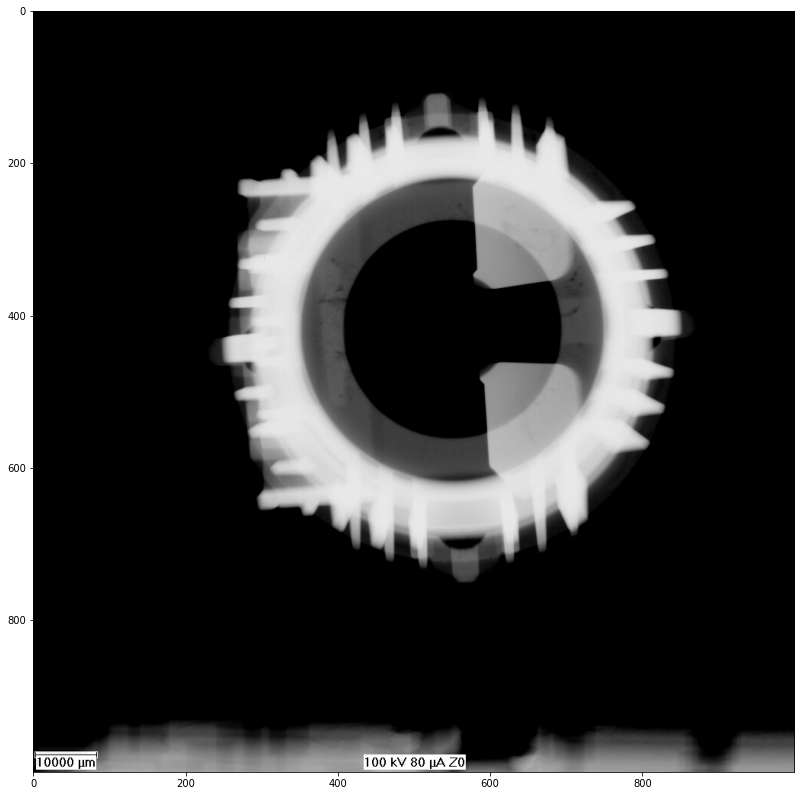

In [2]:
import cv2
import numpy as np

import matplotlib.pyplot as plt
img = cv2.imread("B183.jpg",0)
plt.figure(figsize=(14,14))
plt.imshow(img,cmap="gray")

## 自適應對比增強

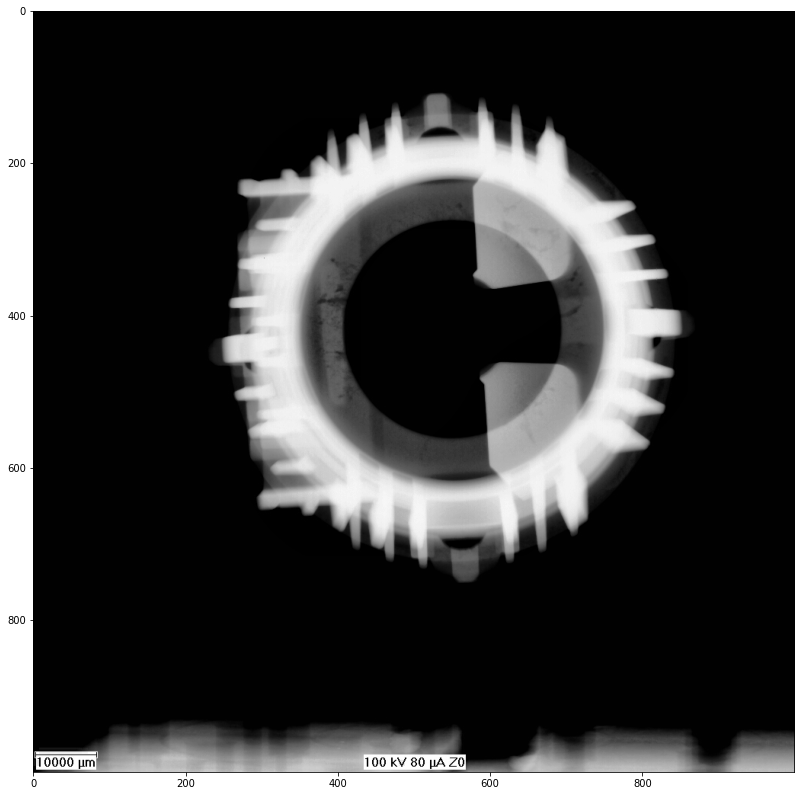

In [3]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(7,7))
cl1 = clahe.apply(img)
plt.figure(figsize=(14,14))
plt.imshow(cl1,cmap="gray")

## 影像平滑&自性應二值化

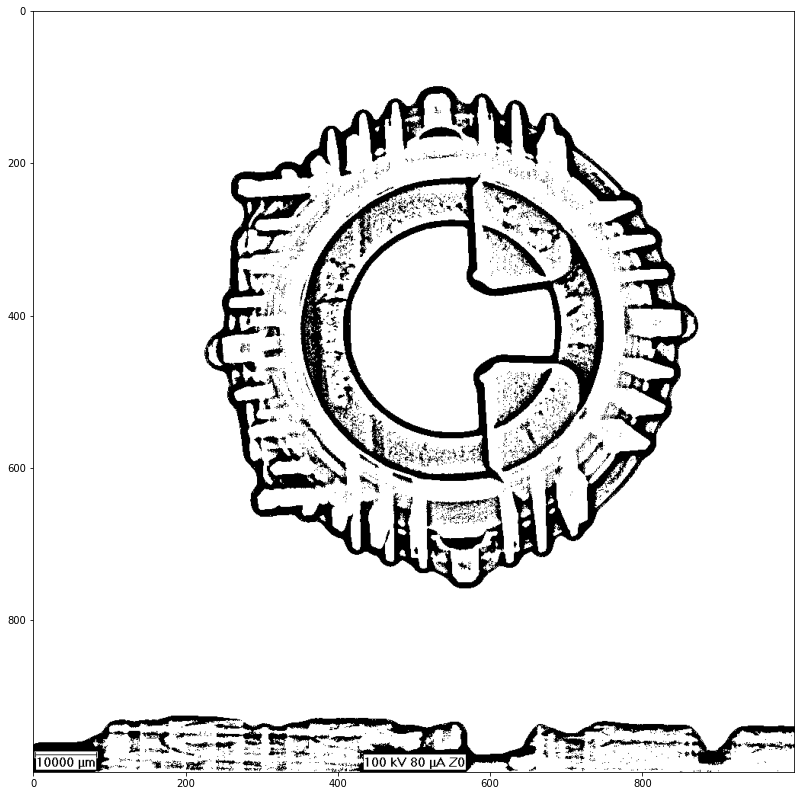

In [34]:
maxValue = 255
b = 31  
C = 2.5 #2.15
adaptiveMethod = cv2.ADAPTIVE_THRESH_GAUSSIAN_C
thresholdType = cv2.THRESH_BINARY 
re = cv2.adaptiveThreshold(cl1, maxValue, adaptiveMethod, thresholdType, b, C)
plt.figure(figsize=(14,14))
plt.imshow(re,cmap="gray")


## 影像雜訊抑制

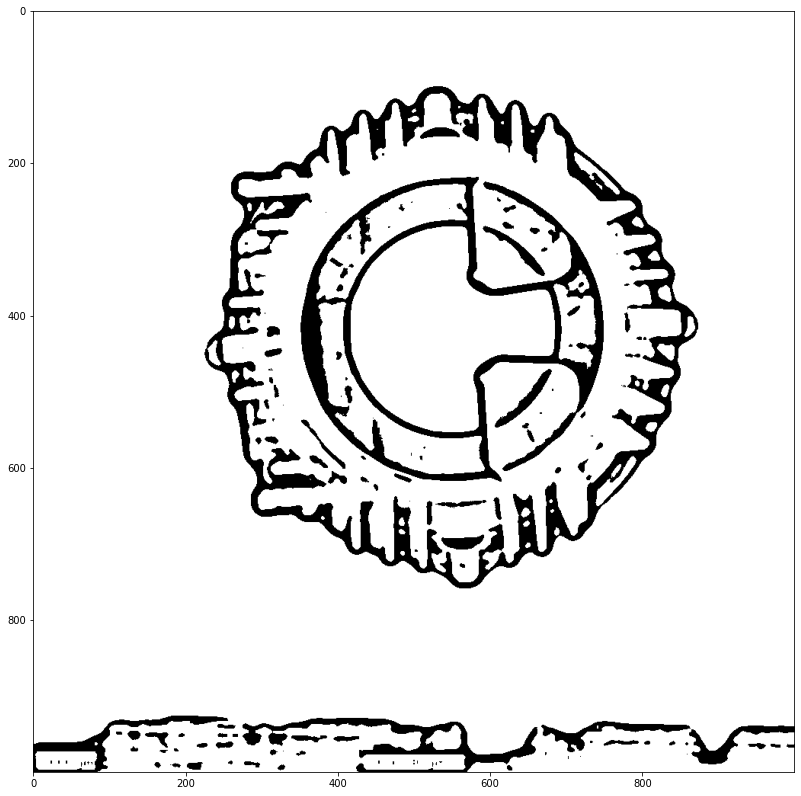

In [35]:
re = cv2.medianBlur(re,7)
plt.figure(figsize=(14,14))
plt.imshow(re,cmap="gray")

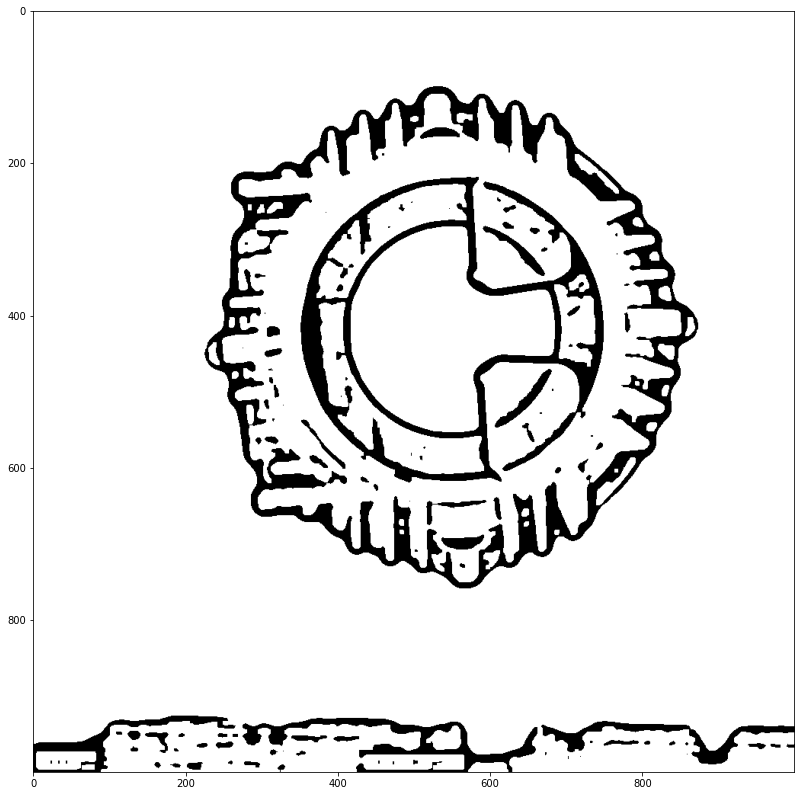

In [36]:

#型態梯度
# kernel = np.ones((4,4),np.uint8) 
# re = cv2.morphologyEx(re, cv2.MORPH_GRADIENT, kernel)
#開運算
kernel = np.ones((5,5),np.uint8) 
re = cv2.morphologyEx(re, cv2.MORPH_OPEN, kernel)
plt.figure(figsize=(14,14))
plt.imshow(re,cmap="gray")

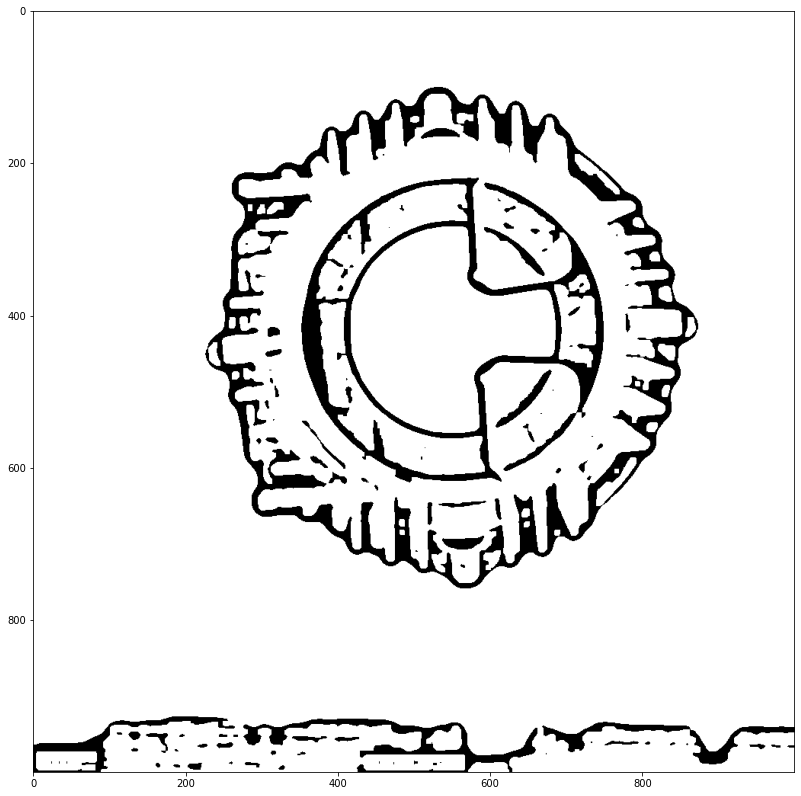

In [37]:
#膨脹
kernel = np.ones((2,2),np.uint8)  
re = cv2.dilate(re, kernel, iterations = 1)
plt.figure(figsize=(14,14))
plt.imshow(re,cmap="gray")

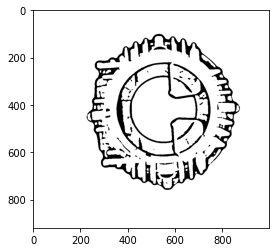

In [39]:
i = re[:-80,:]
plt.imshow(i,cmap="gray")

## 數據增強

In [40]:
!pip install imgaug

In [44]:
from imgaug import augmenters as iaa #引入数据增强的包
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.OneOf([iaa.Affine(rotate=rotate_v) for rotate_v in range(1, 20)])
])

img = []
for addtime in range(20):
  img.append(i)  #opencv读取图片格式是bgr，需要转换成rgb格式
images_aug = seq.augment_images(images=img)

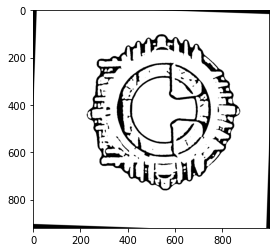

In [48]:
plt.imshow(images_aug[3],cmap="gray")


# 前處理練習（一）螺絲螺紋量測

In [12]:
!pip install imutils
!pip install scipy

[r出現在位置字串前](https://stackoverflow.com/questions/19034822/unknown-python-expression-filename-r-path-to-file)

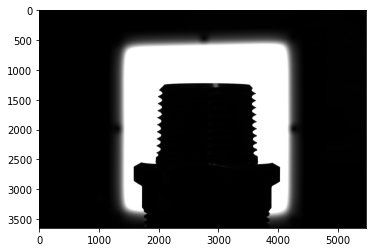

In [49]:
import cv2
import numpy as np

import matplotlib.pyplot as plt
FILE_NAME = r"6.bmp"
imgBGR = cv2.imread(FILE_NAME)
plt.imshow(imgBGR)
plt.show()


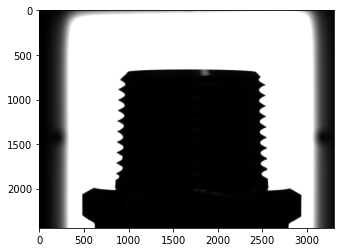

In [50]:
imgBGR = imgBGR[560:3000,1100:4400,:]
plt.imshow(imgBGR)
plt.show()

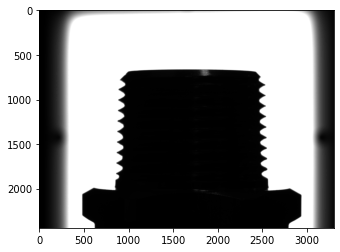

In [51]:
g = cv2.cvtColor(imgBGR,cv2.COLOR_BGR2GRAY) #將圖片轉為灰階處理
plt.imshow(g,cmap="gray")
plt.show()

## 前處理圖片

In [59]:
def remove_bg(g):
    # 增強對比
    def modify_contrast_and_brightness2(img, brightness=0 , contrast=100):
    # contrast = 100 # - 減少對比度/+ 增加對比度
        import math
        B = brightness / 255.0
        c = contrast / 255.0 
        k = math.tan((45 + 44 * c) / 180 * math.pi)

        img = (img - 127.5 * (1 - B)) * k + 127.5 * (1 + B)
        img = np.clip(img, 0, 255).astype(np.uint8)
        return img
    

    light = modify_contrast_and_brightness2(g,contrast=200)
    blur_img = cv2.medianBlur(light,13) #中值律波
    ret, th1 = cv2.threshold(blur_img,127,255,cv2.THRESH_BINARY) #二值化
    


    return th1

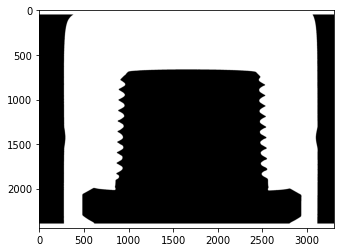

In [60]:
th1= remove_bg(g)
th1[0:50]=255
th1[-50:]=255
plt.imshow(th1,cmap="gray")

In [61]:
def cnt_area(cnt):
  area = cv2.contourArea(cnt)
  return area

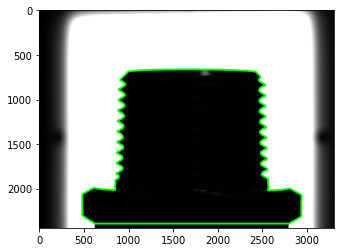

In [80]:
import imutils
cnts = cv2.findContours(th1.copy(), cv2.RETR_TREE,
	cv2.CHAIN_APPROX_NONE)
cnts = list(cnts)[0][:2]
dect = imgBGR.copy()
cv2.drawContours(dect, cnts[1], -1, (0,255,0),  20)
plt.imshow(dect)
plt.show()

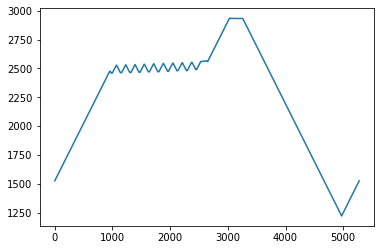

In [81]:
x_th=int(imgBGR.shape[0]/2)

left_cnts = cnts[1][:,0,:][cnts[1][:,0,0] >x_th]
plt.plot(left_cnts[:,0],color="C0")
plt.show()

In [82]:
def remove_outliers(data,idx,n=1.5):
    tr ={}
    for i in idx:
        tr[data[i]]=i
    
    # print(dict)
    
    data = data[idx]


    Q1,_,Q3= np.percentile(data, [25, 50, 75])
    IQR = Q3-Q1
    data = data[data < Q3+n*IQR]
    data = data[data > Q1-n*IQR]
    
    temp = []
    for i in data:
        temp.append(tr[i])
    data= np.array(temp)
    # data = tr[data]

    return data

找到頂點座標X: [ 956 1069 1230 1390 1551 1715 1882 2047 2209 2376 2619 3041]
剔除離群值: [1069 1230 1390 1551 1715 1882 2047 2209 2376 2619]


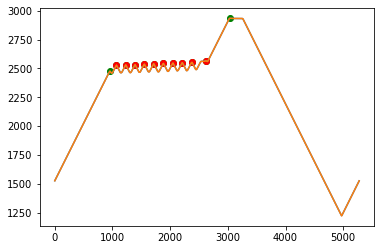

In [83]:
from scipy.signal import savgol_filter,find_peaks,peak_widths,argrelmin,argrelextrema

s = savgol_filter(left_cnts[:,0],15,1)# 平滑
plt.plot(s,color="C0")

plt.plot(left_cnts[:,0],color="C1")

# plt.show()
top_idxs = find_peaks(s,distance=50)[0]# 找峰值
plt.scatter(top_idxs,left_cnts[top_idxs][:,0],c="green")
print("找到頂點座標X:",top_idxs)


top_idxs = remove_outliers(left_cnts[:,0],top_idxs,n=1.5)
plt.scatter(top_idxs,left_cnts[top_idxs][:,0],c="red")
print("剔除離群值:",top_idxs)

In [84]:
def angle(v1, v2):
    import math
    dx1 = v1[2] - v1[0]
    dy1 = v1[3] - v1[1]
    dx2 = v2[2] - v2[0]
    dy2 = v2[3] - v2[1]
    angle1 = math.atan2(dy1, dx1)
    angle1 = int(angle1 * 180/math.pi)
    # print(angle1)
    angle2 = math.atan2(dy2, dx2)
    angle2 = int(angle2 * 180/math.pi)
    # print(angle2)
    if angle1*angle2 >= 0:
        included_angle = abs(angle1-angle2)
    else:
        included_angle = abs(angle1) + abs(angle2)
        if included_angle > 180:
            included_angle = 360 - included_angle
    return included_angle

In [85]:
down_idxs = []
d_array = {}
deep_array = {}
degree_array ={}
for idx,point_idx in enumerate(top_idxs):
    if idx==0:
        last = point_idx
    else:
        #波谷
        down_idx= np.argmin(s[last:point_idx])+last

        down_idxs.append(down_idx)
        #頂點間距離
        d = point_idx-last 
        d_array["{}-{}".format(last,point_idx)] = d # key = 兩個頂點之間距離
        #波谷到兩頂點最短距離
        midpoint_y =(left_cnts[last,0]+left_cnts[point_idx,0])/2
        deep = midpoint_y-left_cnts[down_idx,0]
        deep_array["{}-{}".format(last,point_idx)] = deep
        #兩頂點與波谷夾角
        
        x1p =int((last+down_idx)/2)

        x2p =int((down_idx+point_idx)/2)


        v1 = [x1p,s[x1p],last,s[last]]
        v2 = [x2p,s[x2p],point_idx,s[point_idx]]
        degree = angle(v2,v1)
        # print(degree)
        degree_array["{}-{}".format(last,point_idx)] = degree

        last = point_idx
down_idxs = np.array(down_idxs)
# print("間距:",d_array)
# print("深度:",deep_array)
# print("角度:",degree_array)
# plt.scatter(down_idxs,cntas[down_idxs][:,0],c="blue")

dict = {
    "top_idxs":top_idxs,        # np.array
    "down_idxs": down_idxs,     # np.array
    "d_array":d_array,          # dict
    "deep_array":deep_array,    # dict
    "degree_array":degree_array # dict
} 

In [86]:
def graphic_plt(cnts,analysis_dict):
    fig= plt.figure()
    top_idxs = analysis_dict["top_idxs"]
    down_idxs = analysis_dict["down_idxs"]
    plt.xlim(xmin=top_idxs[0]*0.8,xmax=top_idxs[-1]*1.2)
    plt.ylim(ymin=cnts[down_idxs[0],0]*0.9,ymax=cnts[top_idxs[0],0]*1.1)
    plt.plot(cnts[:,0])
    plt.scatter(top_idxs,cnts[top_idxs][:,0],c="red")
    plt.scatter(down_idxs,cnts[down_idxs][:,0],c="blue")

    for idx,top_idx in enumerate(analysis_dict["top_idxs"]):
        if idx ==0:
            last = top_idx
        else:
            key = "{}-{}".format(last,top_idx)
            plt.hlines(cnts[last,0]*1.05,last,top_idx,colors="green")
            plt.text(last+10,cnts[last,0]*1.054,"{}".format(analysis_dict["d_array"][key]))
            
            deep = analysis_dict["deep_array"][key]
            plt.vlines(down_idxs[idx-1],cnts[down_idxs[idx-1],0],cnts[down_idxs[idx-1],0]+deep,colors="blue")
            plt.text(down_idxs[idx-1]-40,(cnts[down_idxs[idx-1],0]+deep)*1.002,"{}".format(deep),color="blue")
            
            plt.text(down_idxs[idx-1]-10,cnts[down_idxs[idx-1],0]*0.98,"{}".format(analysis_dict["degree_array"][key]))
            last = top_idx
    
    return fig

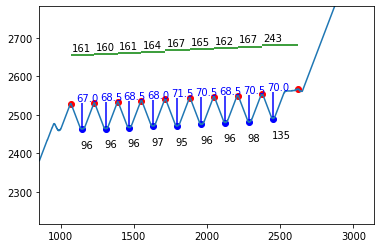

In [26]:
fig= graphic_plt(left_cnts,dict)
fig.show()

In [27]:
def graphic_img(img,cnts,analysis_dict,left=True):
    if left:
        # cv2.imshow(out_win,img)
        down_idxs=analysis_dict["down_idxs"]
        d_array = analysis_dict["d_array"]
        deep_array = analysis_dict["deep_array"]
        degree_array = analysis_dict["degree_array"]
        for idx ,top_idx in enumerate(analysis_dict["top_idxs"]):
            if idx == 0:
                last = top_idx
                cv2.circle(img,tuple(cnts[top_idx]),5,(0,0,255),-1)
            else:
                key = "{}-{}".format(last,top_idx)
                midp = ((cnts[last]+cnts[top_idx])/2).astype("int32")
                sd = 80
                #波峰 波谷
                cv2.circle(img,tuple(cnts[top_idx]),5,(0,0,255),-1)
                cv2.circle(img,tuple(cnts[down_idxs[idx-1]]),5,(255,0,0),-1)

                # 距離
                cv2.line(img, (cnts[last][0]+sd,cnts[last][1]), (cnts[last][0]+sd,cnts[top_idx][1]), (0, 255, 0), 5)
                cv2.putText(img,"{}".format(d_array[key]),(midp[0]+sd+20,midp[1]), cv2.FONT_HERSHEY_SIMPLEX,1, (0, 0, 255), 2, cv2.LINE_AA)
                # 深度
                

                cv2.line(img, tuple(cnts[down_idxs[idx-1]]), tuple(midp), (255, 0, 0), 5)
                cv2.putText(img,"{}".format(deep_array[key]),(midp[0],midp[1]), cv2.FONT_HERSHEY_SIMPLEX,1, (255, 0, 0), 2, cv2.LINE_AA)
                # 角度

                cv2.putText(img,"{}".format(degree_array[key]),(cnts[down_idxs[idx-1]][0]-sd,cnts[down_idxs[idx-1]][1]), cv2.FONT_HERSHEY_SIMPLEX,1, (255, 255, 255), 2, cv2.LINE_AA)
                # print(key)
                last  = top_idx    
        return img
    else:
        pass

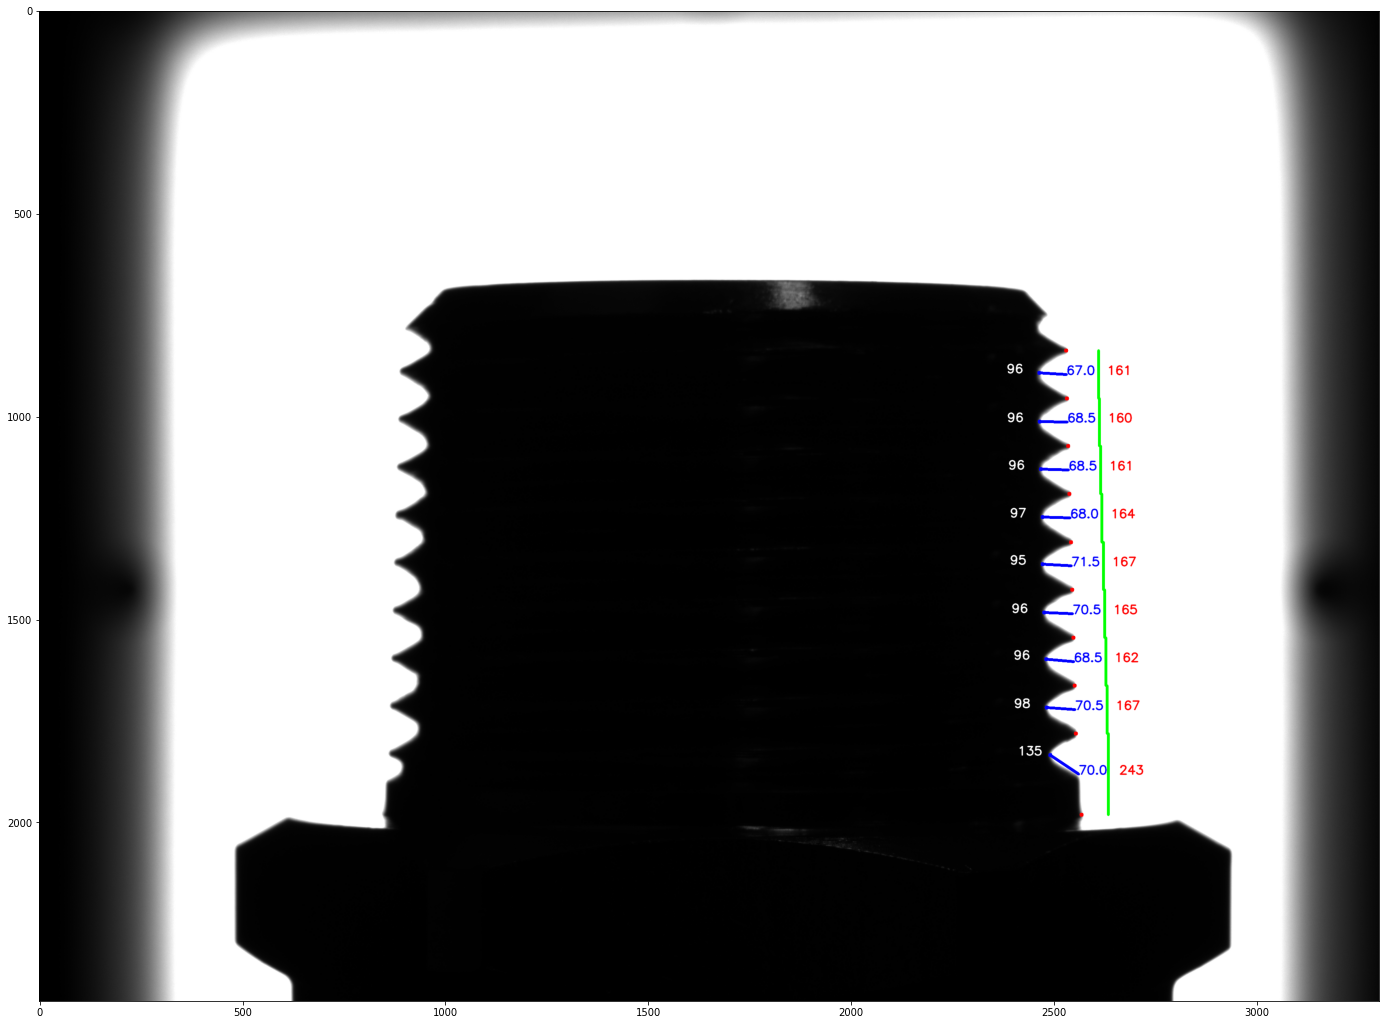

In [28]:
output = graphic_img(imgBGR,left_cnts,dict)
plt.figure(figsize=(24,24))
plt.imshow(output[:,:,::-1])
plt.show()